In [238]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import regex as re
from lxml import etree as et
from itertools import repeat
import csv
import random
import time
from tqdm import tqdm_notebook # tqdm_notebook es una herramienta que permite mostrar barra de progreso al trabajar con bucles grandes
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import math

### **PRE-ANÁLISIS PARA LA LIMPIEZA DE DATOS**

Una vez recopilada la cantidad de datos necesaria para el objeto de estudio, es hora de comenzar la limpieza de datos. 

Para ello,  principalemnte utilizo los métodos .info() y .head() para observar la estrcutura de los datos. Me planteo las siguientes acciones:

- Comprobar que se han recopilado el número de videjuegos necesarios para el estudio. En mi caso quería contar con aproximadamente los 50.000 juegos más relevantes

- Comprobar que los datos se han recopilado en las columnas corrrespondientes a través del web scraping

- Comprobar que los datos corresponden a los de la web. Para ello de forma manual compruebo varios juegos de forma aleatoria y comparo lo que aparece en la web con lo que están en el DataFrame

- Analizar el Dtype de cada variable y ver cuáles de ellas tendrían deberían ser tratadas

- Analizar el número de nulos y otros tipos de valores con caracteres especiales y decidir el tratamiento mas óptimo para los mismos

## **IMPORTANTE**
DEBIDO AL PESO DE LOS ARCHIVOS HE TENIDO QUE QUITAR LOS CSVs ANTIGUOS POR LO QUE SI SE EJECUTAN LAS CELDAS DARÁ ERROR.  

EN CASO DE NECESITARLO TENGO TODAS LAS DIFERENTES COPIAS DE LOS CVS EN SUS DIFERENTES FASES (WEBSCRAPING, LIMPIEZA, ANÁLISIS, ETC)

In [239]:
df = pd.read_csv('data/backloggd_dataset.csv')

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53981 entries, 0 to 53980
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              53979 non-null  object 
 1   Release Date       53981 non-null  object 
 2   Team               36125 non-null  object 
 3   Rating             22920 non-null  float64
 4   Times Listed       53981 non-null  object 
 5   Number of Reviews  53981 non-null  object 
 6   Genres             53981 non-null  object 
 7   Summary            49359 non-null  object 
 8   Reviews            53981 non-null  object 
 9   Platforms          53981 non-null  object 
 10  Plays              53981 non-null  object 
 11  Playing            53981 non-null  object 
 12  Backlogs           53981 non-null  object 
 13  Wishlist           53981 non-null  object 
dtypes: float64(1), object(13)
memory usage: 5.8+ MB


In [110]:
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,"Feb 25, 2022","['FromSoftware', 'Bandai Namco Entertainment']",4.5,6.2K,6.2K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...","['Windows PC, PlayStation 4, Xbox One, PlaySta...",33K,5.2K,8.7K,7.3K
1,The Legend of Zelda: Tears of the Kingdom,"May 12, 2023","['Nintendo', 'Nintendo EPD Production Group No...",4.5,4.2K,4.2K,"['Adventure', 'RPG']",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,['Nintendo Switch'],16K,6.5K,6.3K,6.9K
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo EPD Production Group No. 3', 'Ninte...",4.4,6.6K,6.6K,"['Adventure', 'Puzzle', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","['Wii U, Nintendo Switch']",48K,3.7K,7.6K,3.9K
3,Hades,"Dec 07, 2018",['Supergiant Games'],4.3,4.2K,4.2K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","['Windows PC, Mac, PlayStation 4, Xbox One, Pl...",35K,4.4K,10K,5.3K
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,4.6K,4.6K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","['Windows PC, Mac, Wii U, Linux, Nintendo Swit...",35K,3.6K,13K,3.6K


### **LIMPIEZA DE DATOS Nº1**

Tras realizar el pre-análisis detecto una serie de acciones que son necesarias para poder trabajar correctamente con los datos: 

- **TRATAMIENTO DE VARIABLES**:

    - 'Release Date' a datetime

    - Las variables ['Times Listed', 'Number of Reviews', 'Plays', 'Playing','Backlogs','Wishlist'] son numéricas, pero antes de poder transformarlas hay que realizar ciertas limpiezas:

        - Tratamiento de números negativos
        - Tramiento de valores con caracteres especiales


    - Una vez realizadas las limpiezas las convierto a su DType correcto

- **TRATAMIENTO DE VALORES NULOS**:

    - Analizo detenidamente la estructura de cada variable y aplico una acción específica en cada una de ellas. En el documento se explica detalladamente  
    

   

- **TRATAMIENTOS FINALES**:

    -  Eliminación temporal de la varibale 'Number of Reviews'

    - Cambio de nombre en algunas variables

    - Eliminar filas duplicadas

    - Tabla explicativa de todas las variables


#### **TRATAMIENTO DE VARIABLES**

In [241]:
# Cambiar  al formato de fechas la variable 'Release Date' para poder trabajar de forma eficiente con sus valores
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')

In [242]:
# Tramiento de variables númericas; la mayoría de estas representan los miles con 'K' por lo que es necesario sustituir ese valor de string
# por uno numérico, para ello realizo un replace en los casos donde exista una 'K' y multiplico el valor por 1000 

# Eliminar el sufijo 'K' y convertir a números
columns_to_clean = ['Times Listed', 'Number of Reviews', 'Plays', 'Playing']
for column in columns_to_clean:
    df[column] = df[column].replace('K', 'e3', regex=True).map(pd.eval).astype(float).fillna(df[column]) # utilizo la expresión científica 'e3' porque me estaba dando problemas al multiplicar por 1000 directamente


In [243]:
# Eliminar el sufijo 'K' y convertir a números multiplicando por 1000 en Backlogs y Wishlist
columns_to_clean_backlogs = ['Backlogs', 'Wishlist']

for column in columns_to_clean_backlogs:
    df[column] = df[column].replace('-1', np.nan, regex=True)  # Reemplazar -1 con NaN
    df[column] = df[column].replace(r'([0-9.]+)K', r'\1e3', regex=True).astype(float)  # Convertir con notación científica 'e3' si hay 'K' utlizando una expresión regular


In [114]:
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,2022-02-25,"['FromSoftware', 'Bandai Namco Entertainment']",4.5,6200.0,6200.0,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...","['Windows PC, PlayStation 4, Xbox One, PlaySta...",33000.0,5200.0,8700.0,7300.0
1,The Legend of Zelda: Tears of the Kingdom,2023-05-12,"['Nintendo', 'Nintendo EPD Production Group No...",4.5,4200.0,4200.0,"['Adventure', 'RPG']",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,['Nintendo Switch'],16000.0,6500.0,6300.0,6900.0
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo EPD Production Group No. 3', 'Ninte...",4.4,6600.0,6600.0,"['Adventure', 'Puzzle', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","['Wii U, Nintendo Switch']",48000.0,3700.0,7600.0,3900.0
3,Hades,2018-12-07,['Supergiant Games'],4.3,4200.0,4200.0,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","['Windows PC, Mac, PlayStation 4, Xbox One, Pl...",35000.0,4400.0,10000.0,5300.0
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,4600.0,4600.0,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","['Windows PC, Mac, Wii U, Linux, Nintendo Swit...",35000.0,3600.0,13000.0,3600.0


In [244]:
# Agrupo en una lista las variables numéricas que posteriormente trataré como integrers, la única que es float es 'Rating' por ello no la añado
cols_numericas = ['Times Listed', 'Number of Reviews', 'Plays', 'Playing','Backlogs','Wishlist']

# Analizo todos los números negativos por columna en las columnas numéricas
for column in cols_numericas:
    
    negative_values = df[df[column].astype(float) < 0][column]
    
    if not negative_values.empty:
        print(f"Números negativos en la columna {column}:\n{negative_values}\n")



Números negativos en la columna Plays:
31742   -1.0
33245   -1.0
Name: Plays, dtype: float64

Números negativos en la columna Playing:
29985   -1.0
Name: Playing, dtype: float64



In [245]:
# Descubro que en unos pocos casos hay valores negativos; descubro que se trata de un error de la propia web (no es fallo del web scraping)
# Decido que la mejor acción es cambiarlas a 0, ya que es el valor mínimo que realmente pueden tener
# Reemplazar -1 con 0 en las columnas 'Plays' y 'Playing' específicas
filas_negativos = [31742, 33245, 29985]
df.loc[df.index.isin(filas_negativos), ['Plays', 'Playing']] = df.loc[df.index.isin(filas_negativos), ['Plays', 'Playing']].replace(to_replace=-1, value=0)

In [246]:
# Compruebo que se haya realizado el cambio correctamente
filas_negativos = df.loc[[31742, 33245, 29985]]
filas_negativos

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
31742,Nova the Squirrel,2019-04-29,['NovaSquirrel'],NaN,4.0,4.0,"['Indie', 'Platform']",Nova the Squirrel is an open source NES platfo...,[],['NES'],0.0,0.0,2.0,3.0
33245,Vicewave,2020-12-22,['CyberMotion Games'],NaN,0.0,0.0,"['Adventure', 'Indie']",Welcome back to the 80s! A 20-year-old boy nam...,[],['Windows PC'],0.0,0.0,2.0,0.0
29985,Gomo,2013-12-06,"['Fishcow Studio', 'Daedalic Entertainment']",2.5,12.0,12.0,"['Adventure', 'Indie', 'Point-and-Click', 'Puz...",How far would you go to save your best friend?...,['Gomo es de esos juegos que pasa desapercibid...,"['Windows PC, Mac']",33.0,0.0,32.0,4.0


In [247]:
# Ahora que todas las filas están limpias de negativos y caracteres extraños, covierto las variables numéricas a integrers ya que no necesito decimales y visualmente me molesta que todos los valores acaben en '.0'

# Realizo la acción pero evitar que se aplique a los NaNs porque sino me va dar error; los nulos los trabajaré posteriormente
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce').astype('Int64')

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53981 entries, 0 to 53980
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Title              53979 non-null  object        
 1   Release Date       46359 non-null  datetime64[ns]
 2   Team               36125 non-null  object        
 3   Rating             22920 non-null  float64       
 4   Times Listed       53981 non-null  Int64         
 5   Number of Reviews  53981 non-null  Int64         
 6   Genres             53981 non-null  object        
 7   Summary            49359 non-null  object        
 8   Reviews            53981 non-null  object        
 9   Platforms          53981 non-null  object        
 10  Plays              53981 non-null  Int64         
 11  Playing            53981 non-null  Int64         
 12  Backlogs           53981 non-null  Int64         
 13  Wishlist           53980 non-null  Int64         
dtypes: Int

In [248]:
# Descubro que los valores en 'Times Listed' y 'Number of reviews' son idéticos en todas las filas
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,2022-02-25,"['FromSoftware', 'Bandai Namco Entertainment']",4.5,6200,6200,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...","['Windows PC, PlayStation 4, Xbox One, PlaySta...",33000,5200,8700,7300
1,The Legend of Zelda: Tears of the Kingdom,2023-05-12,"['Nintendo', 'Nintendo EPD Production Group No...",4.5,4200,4200,"['Adventure', 'RPG']",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,['Nintendo Switch'],16000,6500,6300,6900
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo EPD Production Group No. 3', 'Ninte...",4.4,6600,6600,"['Adventure', 'Puzzle', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","['Wii U, Nintendo Switch']",48000,3700,7600,3900
3,Hades,2018-12-07,['Supergiant Games'],4.3,4200,4200,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","['Windows PC, Mac, PlayStation 4, Xbox One, Pl...",35000,4400,10000,5300
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,4600,4600,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","['Windows PC, Mac, Wii U, Linux, Nintendo Swit...",35000,3600,13000,3600


In [249]:
# Analizo el dataset original para comprobar si 'Times Listed' y 'number of reviews' también tienen los valores duplicados
# El dataset 'Games' es el original que ofrecía el dueño en Kaggle, lo que busco es entender si con las modificaciones que hice en mi script modificado 
# cometí algún error que provocará este problema
games = pd.read_csv('./data/games.csv')

In [250]:
# Como se puede observar, el problema también afecta al dataset original; posteriormente trataré este problema (tiene un sentido que no lo aplique ahora :)
games.head()

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


#### **TRATAMIENTO DE VALORES NULOS EN CADA VARIABLE**

In [251]:
# Mostrar filas con valores nulos en la columna 'Title'
null_values_title = df[df['Title'].isnull()]
print("Valores nulos en la columna 'Title':")
null_values_title


Valores nulos en la columna 'Title':


,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
53135,NaN,2020-07-02,NaN,NaN,4,4,['Adventure'],Play as None as they explore their dreams. Thi...,[],['Windows PC'],0,0,0,1
53207,NaN,2020-07-02,NaN,NaN,4,4,['Adventure'],Play as None as they explore their dreams. Thi...,[],['Windows PC'],0,0,0,1


In [252]:
# Decido eliminar estas dos filas, ya que además de no contar con el título, el resto de columnas tampoco recopilan mucha información:
# no son juegos muy relevantes y por lo tanto quedan fuera de mi scope

# Eliminar filas por índice
indices_a_eliminar = [53135, 53207]
df = df.drop(indices_a_eliminar, axis=0)


In [282]:
# Mostrar filas con valores nulos en la columna 'Release Date'
null_values_rdate = df[df['Release Date'].isnull()]
print("Valores nulos en la columna 'Release Date':")
#null_values_rdate # colapsado porque son muchos

Valores nulos en la columna 'Release Date':


In [254]:
# Tras analizar los juegos en la propia web, descubro que se tratan de versiones alpha o beta y que realmente no están en producción y no se sabe la fecha de salida,
# por ello la mayoría no tienen demasiada info relevante. Por ello los elimino ya que quedan fuera del objeto del estudio

# Eliminar filas con valores nulos en la columna 'Release Date'
df = df.dropna(subset=['Release Date'])

In [1]:
# Mostrar filas con valores nulos en la columna 'Team'
null_values_rdate = df[df['Team'].isnull()]
print("Valores nulos en la columna 'Team':")
null_values_rdate.head()

NameError: name 'df' is not defined

In [256]:
# En este caso, creo que el mejor tratamiento posible para los juegos en los que se desconoce el equipo es por el momento sustituir los NaNs por el término "Unknown"
# ya que aplicar la moda a tantos juegos me estará dando info falsa cuando posteriomente quiera filtrar los juegos más populares por compañía
# También descarto por completo eliminar las filas. Posteriormente, dado el caso podría plantear añadir los equipos manualmente o con alguna herramienta
# He comprobado y no es fallo del web-scraping, ya que en la página no están añadidos por alguna razón

# Sustituir NaN por "Unknown" en la columna 'Team'
df['Team'] = df['Team'].fillna("Unknown")

In [257]:
# 'Rating' es una de las variables numéricas más importantes, por ello tengo que tomar la mejor decisión con cuidado respecto al tratamiento de sus nulos
# Me apoyo en el método describe() para mostrar estadísticas descriptivas para la variable
rating_stats = df['Rating'].describe()
rating_stats

count    22413.000000
mean         3.062660
std          0.725125
min          0.200000
25%          2.600000
50%          3.100000
75%          3.600000
max          5.000000
Name: Rating, dtype: float64

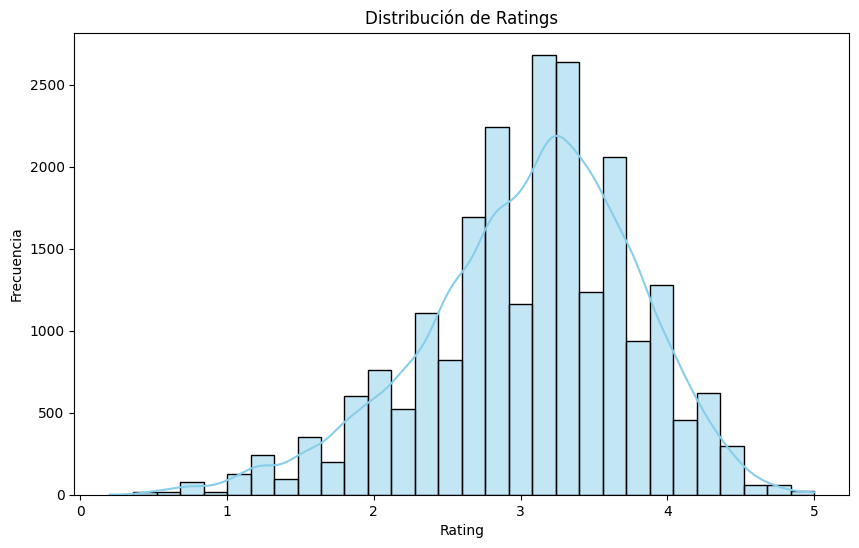

In [130]:
# Hago uso de un histograma para que pueda observar gráficamente la distribución de sus valores
plt.figure(figsize=(10, 6))
sns.histplot(df['Rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

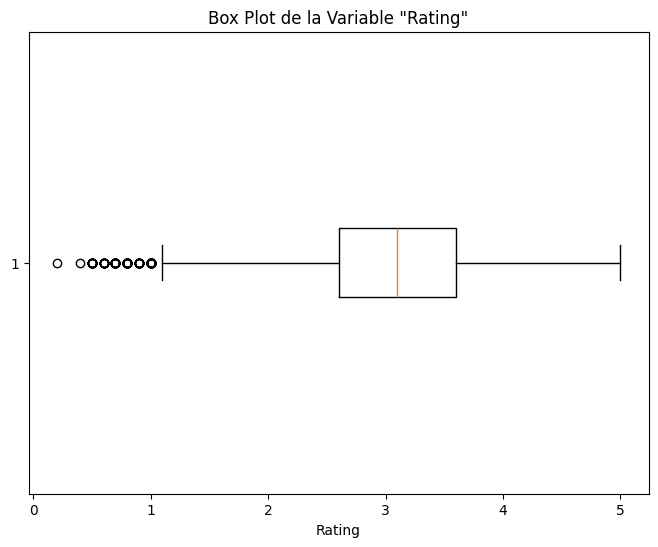

In [131]:
# Crear un box plot para analizar posibles Outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df['Rating'].dropna(), vert=False)
plt.title('Box Plot de la Variable "Rating"')
plt.xlabel('Rating')
plt.show()


In [258]:
# Tras analizar el histograma:
# se puede observar que, entre otras cosas, la desviación estandar es muy baja y por lo tanto no están muy alejados de la media, y que no parece que haya muchos valores posicionados en los extremos
# Además el valor de la media (3.06) y el de la mediana (3.1) están muy cercanos
# Aunque utilizar la media en este caso no sería una mala opción (sobretodo porque no se vería afectada al no exiditir muchos valores en los extremos), prefiero elegir la mediana debido 

# Tras analizar el boxplot:
# Se identifican ciertos valores outliers, que están fuera del bigote de la izquierda; hay pocos juegos con calificaciones extremadamente bajas, pero estas están muy alejadas de la mayoría de las calificaciones

# Una vez sacadas las conclusiones decido aplicar la mediana a los valores nulos de la variable 'Ratings'
# ya que la acción que considero más práctica para representar la calificación típica o central. Es decir imputar la calificación que tienen la mayoría de los juegos

# Obtener la mediana de la variable 'Rating' con el método describe()

mediana_rating = df['Rating'].describe()['50%']

# Sustituir los valores nulos en la columna Rating con la mediana
df['Rating'].fillna(mediana_rating, inplace=True)

In [259]:
# El caso de 'Summary', el mejor tratamiento posible  es el de, por el momento, sustituir los NaNs por el término "Unknown"
# ya que aplicar la moda no tendría ningún sentido ya que se trata de la descripción que es un valor categórico pero único de cada videojuego
# En un principio, no es una variable vital, pero tal vez en las selecciones finales podamos analizar para tratar de sacar una co-relación entre sinopsis y éxito en un videojuego
# En ese caso, más adelante podremos añadir manualmente o mediante otro método los valores faltantes (lo bueno es que los tenemos claramente identificados y sin nulos)

# Sustituir NaN por "Unknown" en la columna 'Team'
df['Summary'] = df['Summary'].fillna("Unknown")

In [260]:
# Se puede observar que ahora todas las variables están limpias y no tienen valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46357 entries, 0 to 53980
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Title              46357 non-null  object        
 1   Release Date       46357 non-null  datetime64[ns]
 2   Team               46357 non-null  object        
 3   Rating             46357 non-null  float64       
 4   Times Listed       46357 non-null  Int64         
 5   Number of Reviews  46357 non-null  Int64         
 6   Genres             46357 non-null  object        
 7   Summary            46357 non-null  object        
 8   Reviews            46357 non-null  object        
 9   Platforms          46357 non-null  object        
 10  Plays              46357 non-null  Int64         
 11  Playing            46357 non-null  Int64         
 12  Backlogs           46357 non-null  Int64         
 13  Wishlist           46357 non-null  Int64         
dtypes: Int64(6)

#### **ACCIONES FINALES**

In [261]:
 # Eliminación temporal de la varibale 'Number of Reviews':
 # no tiene la info correcta; tiene los mismos datos que 'Times Listed'. Compruebo el dataset original y veo que también pasa. Analizo en la web original
 # y detecto que 'Times Listed' recopila la info correctamente y 'Number of Reviews'. Por lo tanto, será un error al realizar el web scraping. Es un dato relevante, por lo que por el momento, 
 # elimino la columna y más adelante cuando tenga una selección final de videojuegos puedo añadirlos a mano o tratar de hacer otro web scraping

# Crea una copia del dataframe limpio antes de eliminar la variable 'Number of Reviews', por si más adelante la necesito
df_variable_nreviews = df.copy()

# Eliminar la variable 'Number of Reviews'
df.drop(['Number of Reviews'], axis=1, inplace=True)



In [262]:
# Cambiar el nombre de la columna 'Rating' a 'Avg. Rating'
df.rename(columns={'Rating': 'Avg. Rating'}, inplace=True)

In [222]:
df.head()

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,2022-02-25,"['FromSoftware', 'Bandai Namco Entertainment']",4.5,6200,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...","['Windows PC, PlayStation 4, Xbox One, PlaySta...",33000,5200,8700,7300
1,The Legend of Zelda: Tears of the Kingdom,2023-05-12,"['Nintendo', 'Nintendo EPD Production Group No...",4.5,4200,"['Adventure', 'RPG']",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,['Nintendo Switch'],16000,6500,6300,6900
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo EPD Production Group No. 3', 'Ninte...",4.4,6600,"['Adventure', 'Puzzle', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","['Wii U, Nintendo Switch']",48000,3700,7600,3900
3,Hades,2018-12-07,['Supergiant Games'],4.3,4200,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","['Windows PC, Mac, PlayStation 4, Xbox One, Pl...",35000,4400,10000,5300
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,4600,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","['Windows PC, Mac, Wii U, Linux, Nintendo Swit...",35000,3600,13000,3600


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46357 entries, 0 to 53980
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         46357 non-null  object        
 1   Release Date  46357 non-null  datetime64[ns]
 2   Team          46357 non-null  object        
 3   Avg. Rating   46357 non-null  float64       
 4   Times Listed  46357 non-null  Int64         
 5   Genres        46357 non-null  object        
 6   Summary       46357 non-null  object        
 7   Reviews       46357 non-null  object        
 8   Platforms     46357 non-null  object        
 9   Plays         46357 non-null  Int64         
 10  Playing       46357 non-null  Int64         
 11  Backlogs      46357 non-null  Int64         
 12  Wishlist      46357 non-null  Int64         
dtypes: Int64(5), datetime64[ns](1), float64(1), object(6)
memory usage: 5.2+ MB


In [263]:
# Elimino filas duplicadas
df.drop_duplicates(inplace=True)
# Reestablezco los índices de nuevo
df.reset_index(drop=True, inplace=True)

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32724 entries, 0 to 32723
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         32724 non-null  object        
 1   Release Date  32724 non-null  datetime64[ns]
 2   Team          32724 non-null  object        
 3   Avg. Rating   32724 non-null  float64       
 4   Times Listed  32724 non-null  Int64         
 5   Genres        32724 non-null  object        
 6   Summary       32724 non-null  object        
 7   Reviews       32724 non-null  object        
 8   Platforms     32724 non-null  object        
 9   Plays         32724 non-null  Int64         
 10  Playing       32724 non-null  Int64         
 11  Backlogs      32724 non-null  Int64         
 12  Wishlist      32724 non-null  Int64         
dtypes: Int64(5), datetime64[ns](1), float64(1), object(6)
memory usage: 3.4+ MB


In [264]:
# Aunque he eliminado las filas duplicadas, tengo que tener en cuenta que hay títulos que están duplicados
# Principalmente es debido a que en muchos casos se realizaron 'remakes' con el mismo título. También hay casos en los que el jueego es prácticamente igual pero se optimizaron versiones para otras plataformas; es muy típico de versiones para móvil
# En los siguientes ejemplos se puede comprobar
# En este caso, sí que me quedo con todos los títulos ya que se trata de versiones diferentes con información relavnte y diferente en cada uno de ellos, sobretodo si se quieren analizar el éxito de remakes o nuevas versiones de juegos clásicos 

# Contando la frecuencia de cada título, pero solo mostrando aquellos que aparecen más de una vez
conteo_titulos = df['Title'].value_counts()
conteo_titulos_filtrados = conteo_titulos[conteo_titulos > 1]

# Configuración que perimite ver todos los resultados
pd.set_option('display.max_rows', None)

conteo_titulos_filtrados

Title
Tetris                                                                                   13
Spider-Man                                                                               10
Pac-Man                                                                                  10
Frogger                                                                                   8
Dig Dug                                                                                   7
Space Invaders                                                                            6
Sonic the Hedgehog                                                                        6
Doom                                                                                      6
Lemmings                                                                                  6
Donkey Kong                                                                               6
Sonic the Hedgehog 2                                                      

In [265]:
# Como se puede observar, aunque el título sea el mismo, cada versión del juego cuenta con su propia información
tetris_titulos = df[df['Title'].str.lower() == 'tetris']
tetris_titulos

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
413,Tetris,1989-11-01,"['Playtronic', 'Nintendo']",4.1,947,"['Arcade', 'Puzzle']",Tetris is a tile-matching puzzle video game. T...,"[""not as good as Dr. Robotnik's Mean Bean Mach...",['NES'],13000,73,265,105
1080,Tetris,1989-05-14,"['Playtronic', 'Nintendo']",4.0,404,['Puzzle'],Tetris is a puzzle video game for the Game Boy...,"['Tetris on the GB was amazing, and still is a...","['Nintendo 3DS, Game Boy']",4300,28,145,32
10323,Tetris,2006-09-12,"['EA', 'Apple']",2.9,6,['Puzzle'],Tetris is a licensed Tetris game for Fifth-Gen...,['iPhone :('],['iOS'],16,0,0,0
11452,Tetris,1984-06-06,['Alexey Pajitnov'],4.1,76,"['Arcade', 'Puzzle']",The original version of Tetris was created by ...,"[""Y'know, I'm not quite sure how I should rate...",['Legacy Computer'],139,0,23,12
14136,Tetris,2006-12-31,"['Sanritsu Denki Co., Ltd.', 'Sega']",2.8,7,[],Tetris was a game for the Sega Mega Drive that...,['No entiendo por qué pone TBD\n ...,"['Sega Mega Drive/Genesis, Arcade']",10,0,2,0
16513,Tetris,1989-12-31,['Sega'],3.1,4,"['Arcade', 'Puzzle']",The System E Arcade System port of Sega's Tetris.,['Cultural merit: 4/5\n \n...,['Arcade'],5,0,1,0
17336,Tetris,1991-12-31,['Tokyo System House'],3.1,3,['Puzzle'],Tetris for the NEC Mini5.,[],['Legacy Computer'],1,0,0,0
18401,Tetris,1989-05-01,['Tengen'],3.9,22,['Puzzle'],"Tengen, an Atari label, released an unlicensed...","['Joguei muito antigamente.', 'This is obvious...",['NES'],108,0,14,11
20562,Tetris,1984-12-31,['Vadim Gerasimov'],3.3,7,"['Arcade', 'Puzzle']",The second version of Tetris was programmed by...,[],['PC DOS'],15,0,1,1
29137,Tetris,2009-08-24,"['EA Mobile', 'EA']",3.1,38,"['Puzzle', 'Strategy']",Don't miss out on one of the best-selling mobi...,['stopped going to therapy when i realized i c...,"['Android, iOS, PlayStation 3, Windows Phone, ...",517,6,18,8


In [266]:
spiderman_titulos = df[df['Title'].str.lower() == 'frogger']
spiderman_titulos

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
3793,Frogger,1997-09-30,"['Hasbro Interactive', 'SCE Cambridge Studio']",2.7,93,"['Adventure', 'Arcade', 'Puzzle']","A remake and reimagining of Frogger. However, ...","['It was ok', 'I think something that tickles ...","['Windows PC, PlayStation']",897,4,86,32
10893,Frogger,1982-12-31,"['Philips do Brasil', 'Parker Brothers']",3.1,0,"['Arcade', 'Platform']",The Videopac G7000 port of the arcade game Fro...,[],['Philips Videopac G7000'],3,0,0,0
14435,Frogger,1983-12-31,['Parker Brothers'],3.1,1,"['Arcade', 'Platform']",The Atari 5200 port of the arcade game Frogger.,[],['Atari 5200'],3,0,0,0
18169,Frogger,1981-12-31,Unknown,1.7,0,[],Frogger (フロッガー) is a 1981 arcade game develope...,[],[''],6,0,1,1
25047,Frogger,2010-12-31,['Konami'],3.1,0,"['Arcade', 'Platform']",A remake of Frogger for mobile devices.,[],"['Android, iOS, Windows Phone']",0,0,0,0
26102,Frogger,1982-12-31,"['Gakken', 'CGL']",3.1,0,"['Arcade', 'Platform']",A tabletop port of the Arcade game Frogger.,[],['Handheld Electronic LCD'],2,0,0,0
28263,Frogger,2002-10-30,['Konami'],3.1,0,"['Arcade', 'Platform']",Frogger is a port of the original game of the ...,[],['Mobile'],0,0,0,0
31204,Frogger,1981-12-31,['Konami'],3.1,0,"['Arcade', 'Platform']",Your task in this arcade game is to guide a fr...,[],"['NEC PC-6000 Series, MSX']",0,0,1,0


In [267]:
# Aunque en la mayoría de los casos, hay ciertos juegos que tienen el mismo nombre (columna 'Title')
# Me he dado cuenta que hay juegos que comparten la misma descripción/resumen exactamente igual pero que tienen los valores casi iguales pero con pequeñas modificaciones:
# Debido a que la información ha variado ligeramente en diferentes momentos de la recopilación (Ejemplo: se recopila el mismo juego pero ha variado el numero de reproducciones frente a la primera recopilación), los duplicados no son idénticos en todas las columnas y por eso no se eliminaron al hacer uso del método 'drop_duplicates'
# En este caso, sí que tengo que eliminar una de las copias, ya que se trata literlmente del mismo juego pero recopilado más de una vez con ligeros cambios
# En este ejemplo se puede observar lo que explico:
title_titulos = df[df['Title'] == "Déraciné"]
title_titulos

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
5616,Déraciné,2018-11-06,"['FromSoftware', 'Sony Interactive Entertainme...",3.7,63,['Adventure'],"""Déraciné is a brand new story adventure creat...","[""What the hell is even this game. It's not aw...",['PlayStation VR'],78,5,84,114
27462,Déraciné,2018-11-06,"['FromSoftware', 'Sony Interactive Entertainme...",3.7,64,['Adventure'],"""Déraciné is a brand new story adventure creat...","[""What the hell is even this game. It's not aw...",['PlayStation VR'],80,5,84,116


In [281]:
# En el siguiente extracto de código identifico todos los títulos que tienen al menos 2 veces el mismo resumen. #Lo tengo copalpsado porque ocupa mucho espacio#
# Agrupando los datos por el resumen y contando la frecuencia de cada título dentro de cada resumen
conteo_resumen_con_titulos = df.groupby('Summary')['Title'].agg(['count', lambda x: ', '.join(x)])
conteo_resumen_con_titulos.columns = ['Count', 'Titles']

# Filtrando solo aquellos resúmenes que aparecen más de una vez
conteo_resumen_con_titulos_filtrados = conteo_resumen_con_titulos[conteo_resumen_con_titulos['Count'] > 1]

# Mostrando los resultados
conteo_resumen_con_titulos_filtrados.head()

,Count,Titles
Summary,,


In [269]:
# A continuación, agrupo los juegos por su resumen, aplicando la función 'obtener_fila_reciente' a cada grupo para obtener la fila más actualizada
# El objetivo es identificar cada una de las filas duplicadas que comparten el mismo resumen y eliminar la menos actualizada

# Definición de la función para obtener los índices de las filas menos recientes (duplicados) de cada grupo
def obtener_indices_recientes(group):
    sorted_group = group.sort_values(by=['Playing', 'Avg. Rating', 'Times Listed', 'Backlogs', 'Wishlist'], ascending=False) # Selecciono las columnas más importante por las que quiero que se filtre
    return sorted_group.index[1:]  # Devolver todos los índices excepto el primero (más reciente)

# Aplicar la función a cada grupo de juegos con el mismo resumen y obtener los índices de las filas menos recientes
indices_to_remove = df.groupby('Summary').apply(obtener_indices_recientes).tolist() # se agrupa por la columna 'Summary', esto crea grupos de filas donde cada grupo contiene filas con el mismo resumen. Aquí es donde se aplica

# Aplanar la lista de índices
indices_to_remove = [index for subgroup in indices_to_remove for index in subgroup]

# Eliminar los índices identificados del DataFrame original
df.drop(indices_to_remove, inplace=True)

# Verificar si los primeros registros se mantienen igual
df.head()



,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,2022-02-25,"['FromSoftware', 'Bandai Namco Entertainment']",4.5,6200,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","['👍', 'A good effort from konami, but at the e...","['Windows PC, PlayStation 4, Xbox One, PlaySta...",33000,5200,8700,7300
1,The Legend of Zelda: Tears of the Kingdom,2023-05-12,"['Nintendo', 'Nintendo EPD Production Group No...",4.5,4200,"['Adventure', 'RPG']",The Legend of Zelda: Tears of the Kingdom is t...,['Legend of Zelda: Tears of the Kingdom is a v...,['Nintendo Switch'],16000,6500,6300,6900
2,The Legend of Zelda: Breath of the Wild,2017-03-03,"['Nintendo EPD Production Group No. 3', 'Ninte...",4.4,6600,"['Adventure', 'Puzzle', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,"['👍', 'very nice game, my first Legend of Zeld...","['Wii U, Nintendo Switch']",48000,3700,7600,3900
3,Hades,2018-12-07,['Supergiant Games'],4.3,4200,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,"[""I enjoyed it quite a bit, but with games lik...","['Windows PC, Mac, PlayStation 4, Xbox One, Pl...",35000,4400,10000,5300
4,Hollow Knight,2017-02-24,['Team Cherry'],4.4,4600,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"['This game is perfect, I immediately fell in ...","['Windows PC, Mac, Wii U, Linux, Nintendo Swit...",35000,3600,13000,3600


In [270]:
# Reestablezco los índices de nuevo
df.reset_index(drop=True, inplace=True)

In [271]:
# Compruebo alguno de los juegos que anteriormente tenían literalmente el mismo 'summary':
# Se puede observar que sólo aparece un título con ese nombre, además también se aprecia que se ha quedado con el título con la información más actualizada

title_titulos = df[df['Title'] == "Déraciné"]
title_titulos

,Title,Release Date,Team,Avg. Rating,Times Listed,Genres,Summary,Reviews,Platforms,Plays,Playing,Backlogs,Wishlist
25337,Déraciné,2018-11-06,"['FromSoftware', 'Sony Interactive Entertainme...",3.7,64,['Adventure'],"""Déraciné is a brand new story adventure creat...","[""What the hell is even this game. It's not aw...",['PlayStation VR'],80,5,84,116


In [235]:
# Vuelvo comprobar si existe un resumen que esté repetido en más de un título
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30208 entries, 0 to 30207
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         30208 non-null  object        
 1   Release Date  30208 non-null  datetime64[ns]
 2   Team          30208 non-null  object        
 3   Avg. Rating   30208 non-null  float64       
 4   Times Listed  30208 non-null  Int64         
 5   Genres        30208 non-null  object        
 6   Summary       30208 non-null  object        
 7   Reviews       30208 non-null  object        
 8   Platforms     30208 non-null  object        
 9   Plays         30208 non-null  Int64         
 10  Playing       30208 non-null  Int64         
 11  Backlogs      30208 non-null  Int64         
 12  Wishlist      30208 non-null  Int64         
dtypes: Int64(5), datetime64[ns](1), float64(1), object(6)
memory usage: 3.1+ MB


In [277]:
# Como tratimento final, descubro que reviews, tiene una serie de duplicados; debido al cotenido del mismo decido eliminar los comentarios repetidos y convertirlos en una lista vacía

# Contando la frecuencia de cada valor en la columna 'Reviews'
conteo_reviews = df['Reviews'].value_counts()

# Filtrando para mostrar solo aquellos valores que aparecen más de una vez
conteo_reviews_duplicados = conteo_reviews[conteo_reviews > 1]

# Mostrando los resultados
conteo_reviews_duplicados

Reviews
[]    14741
Name: count, dtype: int64

In [278]:
# Identificar los índices de las filas con valores duplicados en 'Reviews'
indices_duplicados = df[df['Reviews'].duplicated()].index

# Reemplazar los valores duplicados en 'Reviews' por listas vacías '[]'
df.loc[indices_duplicados, 'Reviews'] = '[]'

In [279]:
# Se puede observar que ahora, los únicos 'duplicados' corresponden a '[]' que corresponden a los juegos que no tienen reviews (son listas vacías)
conteo_reviews_duplicados

Reviews
[]    14741
Name: count, dtype: int64

In [280]:
# Creo un nuevo CSV con todos los cambios aplicados
csv_limpio = 'data/backloggd_dataset_limpio.csv'

# Guardao el DataFrame 'df' en un nuevo archivo CSV con todos los cambios aplicados. Gurado el anterior CVS por si necesitase hacer algún tipo de comprobación más adelante
df.to_csv(csv_limpio, index=False)

| Variable           | Dtype     | Clasificación         | Descripción                                  | Comentarios                                       |
|--------------------|-----------|-----------------------|----------------------------------------------|---------------------------------------------------|
| Title              | object    | Categórica nominal    | Nombre del juego                            |                                                 |
| Release Date       | datetime64| Temporal              | Fecha de lanzamiento              |                                                 |
| Team               | object    | Categórica nominal    | Equipo de desarrollo              |                                                 |
| Avg. Rating        | float64   | Numérica continua     | Calificación promedio del juego             |                                                 |
| Times Listed       | Int64     | Numérica discreta     | Veces que aparece en listas de juegos creadas por usuarios       |                                                 |
| Number of Reviews  | Int64     | Numérica discreta     | Número de reseñas del juego                 |                                                 | La información no se ha obtenido bien de la web. Tal vez tenga sentido hacer un web scraping específico o añadir manualemnte la info po.|
| Genres             | object    | Categórica nominal    | Géneros del juego                           |                                                 |
| Summary            | object    | Categórica nominal    | Resumen del juego                           |                                                 |
| Reviews            | object    | Categórica nominal    | Reseñas del juego                           |                                                 |
| Platforms          | object    | Categórica nominal    | Plataformas en las que se juega             |                                                 |
| Plays              | Int64     | Numérica discreta     | Número de partidas jugadas                  |                                                 |
| Playing            | Int64     | Numérica discreta     | Número de partidas en curso                 |                                                 |
| Backlogs           | Int64     | Numérica discreta     | Número de juegos pendientes de jugar        |                                                 |
| Wishlist           | Int64     | Numérica discreta     | Número de juegos en la lista de deseos      |                                                 |
